## 这是用于计算不同转向方式所需长度的可视化脚本
#### 已经计算的长度
* #### flat_turn
* #### fishtail_turn
* #### backward_moving_turn (suspended)

In [96]:
from CPP_Planner import CPP_Planner_TurningRail_Maker
import matplotlib.pyplot as plt
import math
from math import pi
import numpy as np

### 计算 flat turn

In [97]:

def flat_turn_direc_cost(turning_radius: float, vehicle_length: float, swath_width: float, theta: float, debug=False):
    """
    计算 flat turn 所需的距离
    :param turning_radius: 转向半径
    :param vehicle_length: 机械长度
    :param swath_width: 垄宽
    :param theta: 弧度值，地块边界和当前耕作路径正交直线的夹角
    :param debug
    :return:
    """
    # 不要让 theta 出现 90 度附近接近无穷大的情况，让其在 90 度 +- 20 度之间
    if pi/3 < theta < 2 * pi/3:
        theta = min(theta, pi/3)
    # if pi/3 < theta < 2 * pi/3:
    #     theta = min(theta, pi/3)
    # 计算使用 flat turn 后能够到达的下一条最近的垄
    min_swath_jump = CPP_Planner_TurningRail_Maker.calc_min_swath_jump(turning_radius, swath_width)
    min_jump_width = min_swath_jump * swath_width
    # 计算两个转向半径之间连接所需的距离--pad
    pad = min_jump_width - turning_radius * 2
    # 计算两条垄之间对其的距离差
    swath_gap = min_jump_width * abs(math.tan(theta))
    if debug:
        print("theta: ", theta)
        print("min_swath_jump: ", min_swath_jump)
        print("min_jump_width: ", min_jump_width)
        print("pad: ", pad)
        print("swath_gap: ", swath_gap)
    # calc all
    return pad + swath_gap + pi * turning_radius + vehicle_length

In [98]:
flat_turn_direc_cost(4.5, 4.5, 1.45, 0, debug=True)

theta:  0
min_swath_jump:  7.0
min_jump_width:  10.15
pad:  1.1500000000000004
swath_gap:  0.0


19.78716694115407

In [107]:
def fishtail_turn_direc_cost(turning_radius: float, vehicle_length: float, swath_width: float, theta: float, debug=False):
    """
    计算 fishtail turn 所需的距离
    :param turning_radius: 转向半径
    :param vehicle_length: 机械长度
    :param swath_width: 垄宽
    :param theta: 弧度值，地块边界和当前耕作路径正交直线的夹角
    :param debug
    :return:
    """
    # 放置 theta 达到 90，最大设置到 60度就好了
    if pi/3 < theta < 2 * pi/3:
        theta = min(theta, pi/3)
    pad = turning_radius * 2 - swath_width
    swath_gap = swath_width * abs(math.tan(theta))
    if debug:
        print("theta: ", theta)
        print("pad: ", pad)
        print("swath_gap: ", swath_gap)
    return turning_radius * pi + pad + swath_gap + vehicle_length

In [108]:
fishtail_turn_direc_cost(4.5, 4.5, 1.45, 0, debug=True)

theta:  0
pad:  7.55
swath_gap:  0.0


26.187166941154068

#### 开始分析不同转向方式的路径

In [109]:
# 从 0 到 180 度
degrees = np.arange(0, 180, 1)
print(degrees[:5])
rads = [math.radians(x) for x in degrees]
print(rads[: 5])

[0 1 2 3 4]
[0.0, 0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318]


In [110]:
turning_radius = 4.5
vehicle_length = 4.5
swath_width = 1.45
flat_turns = [flat_turn_direc_cost(turning_radius, vehicle_length, swath_width, theta) for theta in rads]
fishtail_turns = [fishtail_turn_direc_cost(turning_radius, vehicle_length, swath_width, theta) for theta in rads]
print(flat_turns[:5])
print(fishtail_turns[:5])

[19.78716694115407, 19.96433585017548, 20.14161275149531, 20.319105900876938, 20.4969240823807]
[26.187166941154068, 26.212476785299984, 26.2378020569171, 26.263158221114477, 26.28856081847216]


#### 找到两个转向方式距离函数的交点

In [111]:
# 找到 flat_turns fishtail_turns 前半段和后半段分别的最接近的点
flat_turns_first_half = np.array(flat_turns[:90])
flat_turns_second_half = np.array(flat_turns[90:])
fishtail_turns_first_half = np.array(fishtail_turns[:90])
fishtail_turns_second_half = np.array(fishtail_turns[90:])

first_half_min = abs(flat_turns_first_half - fishtail_turns_first_half)
second_half_min = abs(flat_turns_second_half - fishtail_turns_second_half)
closest_index_left = np.argmin(first_half_min)
closest_index_right = np.argmin(second_half_min) + 90
print("flat_turns_first_half_min: ", closest_index_left)
print("flat_turns_second_half_min: ", closest_index_right)

flat_turns_first_half_min:  36
flat_turns_second_half_min:  144


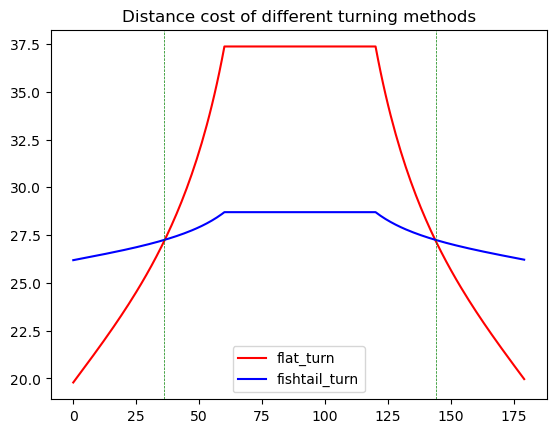

turning_radius:  4.5
vehicle_length:  4.5
swath_width:  1.45


In [112]:
# 展示到一张图上，颜色前者为红色，后者为蓝色
plt.plot(degrees, flat_turns, 'r', degrees, fishtail_turns, 'b')
plt.legend(['flat_turn', 'fishtail_turn'])
# 画两条竖线，分别在 36 和 144 度
plt.axvline(x=closest_index_left, color='g', linestyle='--', linewidth=0.5)
plt.axvline(x=closest_index_right, color='g', linestyle='--', linewidth=0.5)
plt.title("Distance cost of different turning methods")
plt.show()
print("turning_radius: ", turning_radius)
print("vehicle_length: ", vehicle_length)
print("swath_width: ", swath_width)

In [113]:
# 找到 flat_turns fishtail_turns 前半段和后半段分别的最接近的点
flat_turns_first_half = np.array(flat_turns[:90])
flat_turns_second_half = np.array(flat_turns[90:])
fishtail_turns_first_half = np.array(fishtail_turns[:90])
fishtail_turns_second_half = np.array(fishtail_turns[90:])
# 找到最接近的点
flat_turns_first_half_min = 90
flat_turns_first_half_min_index = -1
flat_turns_second_half_min = 90
flat_turns_second_half_min_index = -1
for i in range(90):
    flat = flat_turns_first_half[i]
    fishtail = fishtail_turns_first_half[i]
    # flat_turns_first_half_min = min(abs(fishtail - flat), flat_turns_first_half_min)
    if abs(fishtail - flat) < flat_turns_first_half_min:
        flat_turns_first_half_min_index = i

    flat2 = flat_turns_second_half[i]
    fishtail2 = flat_turns_second_half[i]
    if abs(flat2 - fishtail2) < flat_turns_second_half_min:
        flat_turns_second_half_min_index = i + 90

print("flat_turns_first_half_min: ", flat_turns_first_half_min_index)
print("flat_turns_second_half_min: ", flat_turns_second_half_min_index)


first_half_min = abs(flat_turns_first_half - fishtail_turns_first_half)
second_half_min = abs(flat_turns_second_half - fishtail_turns_second_half)
print(np.argmin(first_half_min))
print(np.argmin(second_half_min))

flat_turns_first_half_min:  89
flat_turns_second_half_min:  179
36
54


Text(0.5, 1.0, 'Distance difference between different turning methods')

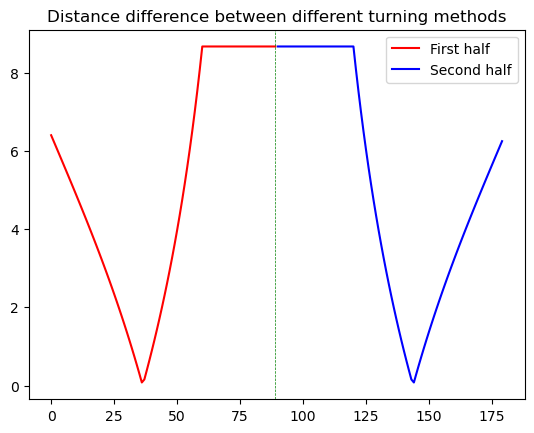

In [114]:
# 画一下 first_half_min 和 second_half_min
plt.plot(degrees[:90], first_half_min, 'r', degrees[90:], second_half_min, 'b')
plt.legend(['First half', 'Second half'])
plt.axvline(x=flat_turns_first_half_min_index, color='g', linestyle='--', linewidth=0.5)
plt.title("Distance difference between different turning methods")